In [0]:
pip install plotly

Python interpreter will be restarted.
Requirement already satisfied: plotly in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e401340c-cd8a-4e28-9d91-849acc3f685f/lib/python3.7/site-packages (4.14.3)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from plotly) (1.14.0)
Requirement already satisfied: retrying>=1.3.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e401340c-cd8a-4e28-9d91-849acc3f685f/lib/python3.7/site-packages (from plotly) (1.3.3)
Python interpreter will be restarted.

In [0]:
pip install plotly-express

Python interpreter will be restarted.
Collecting plotly-express
 Using cached plotly_express-0.4.1-py2.py3-none-any.whl (2.9 kB)
Requirement already satisfied: plotly>=4.1.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e401340c-cd8a-4e28-9d91-849acc3f685f/lib/python3.7/site-packages (from plotly-express) (4.14.3)
Requirement already satisfied: patsy>=0.5 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (0.5.1)
Requirement already satisfied: statsmodels>=0.9.0 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (0.11.0)
Requirement already satisfied: scipy>=0.18 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.4.1)
Requirement already satisfied: pandas>=0.20.0 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.0.1)
Requirement already satisfied: numpy>=1.11 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.18.1)
Requirement already satisfied: python-dateutil>=2.6.1 in /databricks/python3/lib/python3.7/site-packages (from pandas>=0.20.0->plotly-express) (2.8.1)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.7/site-packages (from pandas>=0.20.0->plotly-express) (2019.3)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from patsy>=0.5->plotly-express) (1.14.0)
Requirement already satisfied: retrying>=1.3.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e401340c-cd8a-4e28-9d91-849acc3f685f/lib/python3.7/site-packages (from plotly>=4.1.0->plotly-express) (1.3.3)
Installing collected packages: plotly-express
Successfully installed plotly-express-0.4.1
Python interpreter will be restarted.

In [0]:
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import *
sqCon = SQLContext(sc)
df1 = sqCon.read.format('csv').load("/FileStore/tables/output1.csv",header=True,inferSchema=True)
df2 = sqCon.read.format('csv').load('/FileStore/tables/output2.csv',header=False,inferSchema=True)
df3 = sqCon.read.format('csv').load('/FileStore/tables/output3.csv',header=False,inferSchema=True)
df4 = sqCon.read.format('csv').load('/FileStore/tables/output4.csv',header=False,inferSchema=True)

In [0]:
dfUnion = df1.union(df2).union(df3).union(df4)

In [0]:
df = dfUnion.select('country_code','country_name','year','sex','max_age','age','population').dropDuplicates()

<h3>
<ul>
  <li>From past to present show highest population increase among all countries</li>
</ul>
</h3>

In [0]:
df_midyear_population = spark.read.format("csv").option("header", "true").load("/FileStore/tables/midyear_population.csv")

In [0]:
from pyspark.sql.types import IntegerType
# df_midyear_population = df_midyear_population.withColumn("year", df_midyear_population["year"].cast(IntegerType())
df_midyear_population = df_midyear_population.withColumn("year", df_midyear_population["year"].cast(IntegerType()))\
  .withColumn('midyear_population',df_midyear_population['midyear_population'].cast(IntegerType()))

In [0]:
past_population = df_midyear_population.filter(df_midyear_population["year"] == 1950).withColumnRenamed('midyear_population',"Population in 1950").select('country_name','Population in 1950')
present_population = df_midyear_population.filter(df_midyear_population["year"] == 2020).withColumnRenamed('midyear_population',"Population in 2020").select('country_name','Population in 2020')
pop_increase = past_population.join(present_population,(past_population.country_name==present_population.country_name),"full").drop(present_population['country_name'])
pop_increase = pop_increase.withColumn('Population Increase', col('Population in 2020')-col('Population in 1950')).sort("Population Increase", ascending=False)
# display(pop_increase.limit(3))

In [0]:
import plotly.express as px 
fig = px.bar(pop_increase.toPandas(), x='country_name', y='Population Increase', height=400)
fig.show()

<h3>
<ul>
  <li>Compare to years, highest life expectancy increase among countries</li>
</ul>
</h3>

In [0]:
df_mortality_life_expectancy = spark.read.format("csv").option("header", "true").load("/FileStore/tables/mortality_life_expectancy.csv")

In [0]:
ans = df_mortality_life_expectancy.filter((col("year") >='2000') & (col("year") <="2020")) \
  .groupBy('country_name') \
  .agg(F.avg('life_expectancy').alias('Life Expectancy')) \
  .sort('Life Expectancy',ascending = False)

# display(ans)

In [0]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

<h3>
<ul>
  <li>Average age in a country that have a high life expectancy</li>
</ul>
</h3>

In [0]:
q3 = df.filter((col("year") >='2000') & (col("year") <="2020")).filter(col("age") > 0).groupBy('country_name','age').agg(F.sum('population').alias('population'))
q3 = q3.withColumn('mean of age', col('age') * col('population'))
q3 = q3.groupBy('country_name').sum().select('country_name','sum(population)','sum(mean of age)')
q3 = q3.withColumn("Average Age", col('sum(mean of age)') / col('sum(population)')).drop('sum(population)','sum(mean of age)')
answer = q3.join(ans,(q3.country_name == ans.country_name), 'full').drop(ans['country_name']).sort("Average Age", ascending=False)

In [0]:
answer.show()

+------------+------------------+-----------------+
country_name| Average Age| Life Expectancy|
+------------+------------------+-----------------+
 Monaco| 47.88725733501263|89.02190476190476|
 Japan|44.490354355178624|83.42619047619048|
 Italy| 43.35139107683986| 81.4695238095238|
 Germany| 43.31169513153365|79.81857142857143|
 Greece| 42.54557792929272| 79.74|
 Slovenia| 41.76211949721336|77.05047619047619|
 San Marino| 41.74168576435178|82.72238095238097|
 Austria| 41.62992601077673|80.48238095238096|
 Isle of Man| 41.62525562519566|80.12285714285716|
 Guernsey| 41.56461578885861|81.61142857142858|
 Bulgaria| 41.48977247780416|73.22714285714287|
 Finland| 41.23805891287306|79.79571428571428|
 Spain|41.224856354371134|80.87904761904761|
 Croatia|41.192786450170686| 74.9947619047619|
 Sweden| 41.09711196863328|81.26238095238095|
 Serbia|41.086661504874506|74.10619047619048|
 Switzerland| 41.0707432142198|81.74380952380953|
 Latvia|40.971302151922664|72.50666666666669|
 Estonia| 40.8971483798696| 74.3442857142857|
 Belgium|40.894181466166145| 79.8652380952381|
+------------+------------------+-----------------+
only showing top 20 rows

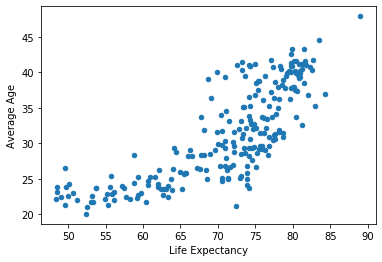

In [0]:
answerplt= answer.toPandas()
answerplt.plot(x='Life Expectancy', y='Average Age', kind='scatter')
display()

<h3>
<ul>
  <li>Infant mortality rate in a country that have a high life expectancy.</li>
</ul>
</h3>

In [0]:
inf = df_mortality_life_expectancy.filter(df_mortality_life_expectancy['year'].isin(2000))
inf = inf.select(inf["country_name"],inf["year"],inf["infant_mortality"],inf["life_expectancy"])
infant_mortality = inf.sort("infant_mortality", ascending=False)
display(infant_mortality)

country_name,year,infant_mortality,life_expectancy
Ethiopia,2000,99.31,51.81
Equatorial Guinea,2000,99.16,58.42
Burkina Faso,2000,99.00,48.87
Congo (Kinshasa),2000,98.40,51.80
Gambia The,2000,94.55,59.60
Burundi,2000,91.96,49.24
Rwanda,2000,90.75,46.44
Belarus,2000,9.37,69.06
Hungary,2000,9.34,71.51
Qatar,2000,9.16,75.76


<h3>
<ul>
  <li>CRUDE BIRTH RATE ON WORLD MAP</li>
</ul>
</h3>

In [0]:
import numpy as np # linear algebra
import pandas as pd
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import *
sqCon = SQLContext(sc)
# df_birth_death_growth_rates = pd.read_csv("/dbfs/FileStore/tables/birth_death_growth_rates.csv")
df_birth_death_growth_rates = sqCon.read.format("csv").load("/FileStore/tables/birth_death_growth_rates.csv",header='true')
df_birth_death_growth_rates = df_birth_death_growth_rates.withColumnRenamed('country_name', 'Country')

df_covid = sqCon.read.format("csv").load("/FileStore/tables/COVID19_son1.csv",header='true')
df_covid = df_covid.withColumnRenamed('Country/Region', 'Country')
df_covid = df_covid.select(['Country','Lat','Long'])

In [0]:
df_birth_death_growth_rates = df_birth_death_growth_rates.join(df_covid,(df_birth_death_growth_rates.Country == df_covid.Country), 'full').drop(df_covid['Country'])
new = df_birth_death_growth_rates.filter(df_birth_death_growth_rates['Lat'].isNotNull())
# display(new.select('Country').dropDuplicates())

In [0]:
!pip install plotly

Requirement already satisfied: plotly in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e401340c-cd8a-4e28-9d91-849acc3f685f/lib/python3.7/site-packages (4.14.3)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from plotly) (1.14.0)
Requirement already satisfied: retrying>=1.3.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e401340c-cd8a-4e28-9d91-849acc3f685f/lib/python3.7/site-packages (from plotly) (1.3.3)

In [0]:
geo = new.groupBy("Lat","Long").agg(F.count(new['crude_birth_rate']).alias("crude_birth_rate"))
geo = geo.filter(geo['crude_birth_rate'].isNotNull())

In [0]:
# geo2 = df.groupBy('Lat','Long')

In [0]:
import plotly.graph_objects as go

def plot_map(dataframe,focusOn):
  fig = go.Figure(data=go.Scattergeo(
          lon = dataframe['Long'],
          lat = dataframe['Lat'],
          mode = 'markers',
          marker_color = dataframe[focusOn],
            marker = dict(
              size = 9,
              opacity = 0.8,
              reversescale = True,
              autocolorscale = True,
              symbol = 'square',
              line = dict(
                  width=2,
                  color='white'
              ),
              colorscale = 'teal',
              cmin = 0,
              color = dataframe[focusOn],
              cmax = dataframe[focusOn].max(),
              colorbar_title="The range of {}".format(focusOn))
          ))

  fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
          title = 'Plot',
      )
  fig.show()

In [0]:
plot_map(geo.toPandas(),'crude_birth_rate')

In [0]:
import plotly.express as px

turkey = df_birth_death_growth_rates.filter(df_birth_death_growth_rates['Country']== 'Turkey')
fig = px.bar(turkey.toPandas(), x='year', y='crude_birth_rate',
              height=400)
fig.show()

In [0]:
import plotly.express as px

turkey = df.filter(df['country_name']== 'Turkey').filter(df['year'] == '2020')
fig = px.bar(turkey.toPandas(), x='age', y='population',
              height=400)
fig.show()

In [0]:
# df_midyear_population.groupBy('country_name').agg(F.sum('midyear_population')).show()
# # df_midyear_population.dropDuplicates().show()

a = df_midyear_population.filter(df_midyear_population['year']<2021).groupBy('year').agg(F.avg('midyear_population')).withColumn("midyear_population", col("avg(midyear_population)").cast("Integer")).drop('avg(midyear_population)')

a.show()

b = df_midyear_population.filter(df_midyear_population['year']>2021).groupBy('year').agg(F.avg('midyear_population')).withColumn("midyear_population", col("avg(midyear_population)").cast("Integer")).drop('avg(midyear_population)')

b.show()

+----+------------------+
year|midyear_population|
+----+------------------+
1959| 13161037|
1990| 23172162|
1975| 17930035|
1977| 18547731|
2003| 27690304|
2007| 29043390|
2018| 32798051|
1974| 17616638|
2015| 31777630|
1955| 12202188|
2006| 28701700|
1978| 18858494|
1961| 13526170|
2013| 31098394|
1952| 11564790|
1956| 12435524|
1997| 25676927|
1988| 22402662|
1994| 24625850|
1968| 15624183|
+----+------------------+
only showing top 20 rows

+----+------------------+
year|midyear_population|
+----+------------------+
2025| 35040723|
2027| 35635068|
2035| 37810751|
2044| 39915352|
2032| 37030612|
2023| 34425336|
2047| 40536985|
2022| 34109723|
2031| 36761345|
2042| 39477863|
2038| 38551062|
2037| 38308511|
2045| 40127125|
2040| 39023036|
2026| 35340400|
2041| 39252520|
2036| 38061713|
2048| 40734959|
2029| 36208651|
2046| 40334307|
+----+------------------+
only showing top 20 rows

In [0]:
import plotly.express as px

fig = px.bar(a.toPandas(), x='year', y='midyear_population',color='year',
              height=500)
fig.show() 

In [0]:
fig1 = px.bar(b.toPandas(), x='year', y='midyear_population',color= 'midyear_population',
              height=400)
fig1.show()

In [0]:
frame = sqCon.read.format('csv').load("/FileStore/tables/midyear_population_age_sex.csv",header=True,inferSchema=True)

In [0]:
df = df.withColumn('sex',F.when(df['sex']=='Female',0).otherwise(1))
display(df.limit(10))

country_code,country_name,year,sex,max_age,age,population
ES,El Salvador,2046,0,100,27,36540
CV,Cabo Verde,2033,0,100,74,1763
GV,Guinea,1978,1,97,42,17973
BD,Bermuda,2041,0,100,11,385
MZ,Mozambique,1989,1,100,24,98708
TW,Taiwan,1994,1,100,2,165565
SL,Sierra Leone,2000,1,100,40,14235
RS,Russia,2045,1,100,10,650473
BX,Brunei,1991,1,100,10,2979
GR,Greece,2032,1,100,1,44906


In [0]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['year','sex','age','population'],outputCol='features')

In [0]:
df = df.withColumn("country_code", df["country_code"].cast('string'))\
        .withColumn("country_name", df["country_name"].cast('string'))

In [0]:
output = assembler.transform(df)
output.show()
# display(output.select('Churn'))

+------------+--------------------+----+---+-------+---+----------+--------------------+
country_code| country_name|year|sex|max_age|age|population| features|
+------------+--------------------+----+---+-------+---+----------+--------------------+
 GM| Germany|2002| 1| 100| 13| 493198|[2002.0,1.0,13.0,...|
 BT| Bhutan|2023| 0| 100| 26| 6906|[2023.0,0.0,26.0,...|
 ES| El Salvador|2021| 1| 100| 57| 23018|[2021.0,1.0,57.0,...|
 MK| Macedonia|1998| 0| 100| 90| 285|[1998.0,0.0,90.0,...|
 TO| Togo|2038| 0| 100| 4| 156354|[2038.0,0.0,4.0,1...|
 CH| China|2038| 0| 100| 16| 7273714|[2038.0,0.0,16.0,...|
 GY| Guyana|2024| 0| 100| 40| 4153|[2024.0,0.0,40.0,...|
 BD| Bermuda|2029| 0| 100| 95| 64|[2029.0,0.0,95.0,...|
 TN| Tonga|2036| 0| 100| 47| 559|[2036.0,0.0,47.0,...|
 BK|Bosnia and Herzeg...|2004| 0| 100| 31| 30761|[2004.0,0.0,31.0,...|
 BR| Brazil|1990| 0| 100| 50| 581936|[1990.0,0.0,50.0,...|
 TP|Sao Tome and Prin...|2000| 0| 100| 44| 496|[2000.0,0.0,44.0,...|
 UZ| Uzbekistan|2043| 0| 100| 28| 224120|[2043.0,0.0,28.0,...|
 NU| Nicaragua|1979| 0| 100| 53| 7075|[1979.0,0.0,53.0,...|
 MK| Macedonia|2026| 1| 100| 38| 16394|[2026.0,1.0,38.0,...|
 CO| Colombia|2041| 0| 100| 18| 353541|[2041.0,0.0,18.0,...|
 NP| Nepal|1994| 1| 100| 12| 250034|[1994.0,1.0,12.0,...|
 SB|Saint Pierre and ...|2025| 0| 100| 80| 28|[2025.0,0.0,80.0,...|
 TS| Tunisia|2002| 1| 100| 14| 104555|[2002.0,1.0,14.0,...|
 IZ| Iraq|2004| 0| 100| 68| 26960|[2004.0,0.0,68.0,...|
+------------+--------------------+----+---+-------+---+----------+--------------------+
only showing top 20 rows

In [0]:
final_data = output.select('features','sex')

In [0]:
train_sex,test_sex = final_data.randomSplit([0.7,0.3])

In [0]:
from pyspark.ml.classification import LogisticRegression

In [0]:
lr_sex = LogisticRegression(labelCol='sex')

In [0]:
fitted_sex_model = lr_sex.fit(train_sex)

In [0]:
training_sum = fitted_sex_model.summary
training_sum.predictions.show()

+--------------------+---+--------------------+--------------------+----------+
 features|sex| rawPrediction| probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
[1950.0,0.0,7.0,1...|0.0|[21.6918862393261...|[0.99999999962039...| 0.0|
[1950.0,0.0,10.0,...|0.0|[21.6922454656956...|[0.99999999962053...| 0.0|
[1950.0,0.0,15.0,...|0.0|[21.6928195693829...|[0.99999999962074...| 0.0|
[1950.0,0.0,33.0,...|0.0|[21.6949960860736...|[0.99999999962157...| 0.0|
[1950.0,0.0,42.0,...|0.0|[21.6960709036982...|[0.99999999962197...| 0.0|
[1950.0,0.0,62.0,...|0.0|[21.6984537132545...|[0.99999999962287...| 0.0|
[1950.0,0.0,68.0,...|0.0|[21.6991731565073...|[0.99999999962314...| 0.0|
[1950.0,0.0,95.0,...|0.0|[21.7023901530139...|[0.99999999962436...| 0.0|
[1950.0,1.0,0.0,3...|1.0|[-22.634048632552...|[1.47964515255321...| 1.0|
[1950.0,1.0,23.0,...|1.0|[-22.631253521599...|[1.48378671028441...| 1.0|
[1950.0,1.0,25.0,...|1.0|[-22.630994181222...|[1.48417156599247...| 1.0|
[1950.0,1.0,68.0,...|1.0|[-22.625862622258...|[1.49180725463232...| 1.0|
[1950.0,1.0,76.0,...|1.0|[-22.624906317786...|[1.49323455894122...| 1.0|
[1950.0,1.0,76.0,...|1.0|[-22.624907308299...|[1.49323307987264...| 1.0|
[1950.0,1.0,85.0,...|1.0|[-22.623834361645...|[1.49483609913272...| 1.0|
[1950.0,1.0,93.0,...|1.0|[-22.622881689057...|[1.49626086706937...| 1.0|
[1951.0,0.0,2.0,2...|0.0|[21.7023656059203...|[0.99999999962435...| 0.0|
[1951.0,0.0,5.0,2...|0.0|[21.7027330315423...|[0.99999999962448...| 0.0|
[1951.0,0.0,20.0,...|0.0|[21.7045432506962...|[0.99999999962516...| 0.0|
[1951.0,0.0,40.0,...|0.0|[21.7069440545849...|[0.99999999962606...| 0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 20 rows

In [0]:
training_sum.predictions.describe().show()

+-------+------------------+------------------+
summary| sex| prediction|
+-------+------------------+------------------+
 count| 2141782| 2141782|
 mean|0.5002647328252828|0.5002647328252828|
 stddev|0.5000000466417818|0.5000000466417818|
 min| 0.0| 0.0|
 max| 1.0| 1.0|
+-------+------------------+------------------+

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
pred_and_labels = fitted_sex_model.evaluate(test_sex)

In [0]:
pred_and_labels.predictions.show()

+--------------------+---+--------------------+--------------------+----------+
 features|sex| rawPrediction| probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
[1950.0,0.0,6.0,2...| 0|[21.6917333058220...|[0.99999999962033...| 0.0|
[1950.0,0.0,9.0,2...| 0|[21.6920961090467...|[0.99999999962047...| 0.0|
[1950.0,0.0,16.0,...| 0|[21.6929399810199...|[0.99999999962079...| 0.0|
[1950.0,0.0,28.0,...| 0|[21.6943829396375...|[0.99999999962134...| 0.0|
[1950.0,0.0,38.0,...| 0|[21.6955822134968...|[0.99999999962179...| 0.0|
[1950.0,0.0,49.0,...| 0|[21.6968989824806...|[0.99999999962229...| 0.0|
[1950.0,0.0,76.0,...| 0|[21.7001262418099...|[0.99999999962350...| 0.0|
[1950.0,1.0,1.0,1...| 1|[-22.633869367892...|[1.47991042441497...| 1.0|
[1950.0,1.0,82.0,...| 1|[-22.624191386873...|[1.49430250019356...| 1.0|
[1950.0,1.0,89.0,...| 1|[-22.623357942808...|[1.49554843688064...| 1.0|
[1951.0,0.0,17.0,...| 0|[21.7041820432992...|[0.99999999962503...| 0.0|
[1951.0,0.0,18.0,...| 0|[21.7043250441518...|[0.99999999962508...| 0.0|
[1951.0,1.0,21.0,...| 1|[-22.620372336546...|[1.50002022784020...| 1.0|
[1951.0,1.0,30.0,...| 1|[-22.619290667868...|[1.50164363057008...| 1.0|
[1951.0,1.0,35.0,...| 1|[-22.618676558433...|[1.50256608730808...| 1.0|
[1951.0,1.0,39.0,...| 1|[-22.618198681339...|[1.50328430081758...| 1.0|
[1951.0,1.0,46.0,...| 1|[-22.617372280927...|[1.50452712904900...| 1.0|
[1951.0,1.0,62.0,...| 1|[-22.615453151101...|[1.50741728434077...| 1.0|
[1952.0,0.0,39.0,...| 0|[21.7179577850686...|[0.99999999963016...| 0.0|
[1952.0,0.0,67.0,...| 0|[21.7212994028955...|[0.99999999963139...| 0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 20 rows

In [0]:
sex_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                           labelCol='sex')

In [0]:
auc = sex_eval.evaluate(pred_and_labels.predictions)

In [0]:
auc

Out[44]: 1.0